<a href="https://colab.research.google.com/github/wayne0git/ml_cv_basics/blob/master/adaboost_classification_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Adaboost Classification Example
Ref -- https://machinelearningmastery.com/adaboost-ensemble-in-python/

### Package Information

In [51]:
import numpy as np
import sklearn

from matplotlib import pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV

In [13]:
np.__version__, sklearn.__version__

('1.18.5', '0.22.2.post1')

### Constant / Parameter

In [46]:
SEED = 0

# Data
DATA_N_SAMPLE = 1000
DATA_N_CLASS = 2
DATA_N_FEATURE = 20
DATA_N_INFO = 15                    # Gaussian clusters
DATA_N_REDUNANT = DATA_N_FEATURE - DATA_N_INFO   # Random
DATA_SPLIT = 0.2                    # Train / Test Split.

# Cross validation
CV_SPLIT = 5
CV_REPEAT = 2

# Model hyperparameters
HP_MODEL_N_EST = [10, 50, 100]
HP_MODEL_LR = [0.0001, 0.001, 0.01]

### Data Preparation

In [8]:
# Create a synthetic binary classification problem
# x: (#Data, #Feature), y: (#Data, )
x, y = make_classification(n_samples=DATA_N_SAMPLE,
               n_features=DATA_N_FEATURE,
               n_informative=DATA_N_INFO,
               n_redundant=DATA_N_REDUNANT,
               n_classes=DATA_N_CLASS, random_state=SEED)

In [40]:
# Train / Test Set Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=DATA_SPLIT)

### Create Model

In [96]:
model = AdaBoostClassifier(n_estimators=10)

### Train Model

In [97]:
model.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=10, random_state=None)

### Examine Model (Assume depth-1 decision tree as base estimator)

In [98]:
# Adaboost consists of many weak learners (e.g. decision trees)
model.n_estimators, model.estimators_[0]

(10, DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=1, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=1405320648, splitter='best'))

In [99]:
# Each decision tree makes its own decision
dt0 = model.estimators_[0]

print('Predicted Node Index of 1st tree: %s' % str(dt0.apply(x_test[:2])))
print('Predicted Class of 1st tree: %s' % str(dt0.predict(x_test[:2])))
print('Real Class: %s' % str(y_test[:2]))

Predicted Node Index of 1st tree: [1 2]
Predicted Class of 1st tree: [1 0]
Real Class: [0 1]


In [100]:
# The tree decides based on the selected feature and threshold
# -2 => No condition in leaf nodess
print('Selected feature index of 1st tree: %s' % str(dt0.tree_.feature))
print('Threshold value of 1st tree: %s' % str(dt0.tree_.threshold))
print('Selected feature values of test data: %s' % str(x_test[:2, dt0.tree_.feature[0]]))

Selected feature index of 1st tree: [12 -2 -2]
Threshold value of 1st tree: [-0.1868474 -2.        -2.       ]
Selected feature values of test data: [-0.4497535  0.5389624]


In [144]:
# The weight of each node is determined from the node value
for eid, dt in enumerate(model.estimators_):
    proba_n = np.squeeze(dt.tree_.value / dt.tree_.value.sum(axis=2)[..., np.newaxis])
    log_proba = np.log(np.clip(proba_n, np.finfo(proba_n.dtype).eps, None))
    print('Tree %d' % eid, (log_proba - log_proba.mean(axis=1)[:, np.newaxis])[:, 0] * 2 * (-1))

Tree 0 [-0.05001042  0.6883739  -0.52181475]
Tree 1 [-8.43769499e-15  4.94454374e-01 -4.10169817e-01]
Tree 2 [ 1.08801856e-14 -3.14901529e-01  7.53800978e-01]
Tree 3 [ 2.22044605e-15  2.38192099e-01 -9.75368027e-01]
Tree 4 [-5.55111512e-15 -2.13241004e+00  1.04391983e-01]
Tree 5 [ 5.77315973e-15 -9.00237898e-01  1.83895752e-01]
Tree 6 [ 2.66453526e-15  1.39904777e+00 -9.60547230e-02]
Tree 7 [-1.33226763e-15 -2.41762217e-01  5.73074365e-01]
Tree 8 [ 3.55271368e-15  6.19821255e-01 -2.24205384e-01]
Tree 9 [-1.11022302e-15 -2.94084426e-01  4.02090358e-01]


In [146]:
# Final Adabost decision value can be computed from summing the decision tree results
decision_value_sum = 0
for eid, dt in enumerate(model.estimators_):
    log_proba = dt.predict_log_proba(x_test[:1])
    leaf_val = (log_proba - log_proba.mean(axis=1)[:, np.newaxis])[0, 0] * 2 * (-1)
    decision_value_sum += leaf_val
    print('Tree %d, Leaf Val: %.2f, Decision Val: %.2f' % (eid, leaf_val, decision_value_sum / (eid + 1)))

Tree 0, Leaf Val: 0.69, Decision Val: 0.69
Tree 1, Leaf Val: 0.49, Decision Val: 0.59
Tree 2, Leaf Val: 0.75, Decision Val: 0.65
Tree 3, Leaf Val: 0.24, Decision Val: 0.54
Tree 4, Leaf Val: 0.10, Decision Val: 0.46
Tree 5, Leaf Val: 0.18, Decision Val: 0.41
Tree 6, Leaf Val: -0.10, Decision Val: 0.34
Tree 7, Leaf Val: -0.24, Decision Val: 0.27
Tree 8, Leaf Val: 0.62, Decision Val: 0.31
Tree 9, Leaf Val: 0.40, Decision Val: 0.31


In [142]:
# The final decision value depends on the weighted value of all decision trees
model.decision_function(x_test[:1]), list(model.staged_decision_function(x_test[:1]))

(array([0.31472038]),
 [array([0.6883739]),
  array([0.59141414]),
  array([0.64554308]),
  array([0.54370534]),
  array([0.45584267]),
  array([0.41051818]),
  array([0.33815062]),
  array([0.26566152]),
  array([0.3050126]),
  array([0.31472038])])

### Hyperparameter Optimization

In [43]:
# Repeats cross validation for n times with different randomization
cv = RepeatedStratifiedKFold(n_splits=CV_SPLIT, n_repeats=CV_REPEAT, random_state=SEED)

In [ ]:
# Grid search
params_grid = {}
params_grid['n_estimators'] = HP_MODEL_N_EST
params_grid['learning_rate'] = HP_MODEL_LR

clf = GridSearchCV(model, params_grid, n_jobs=-1, cv=cv, scoring='accuracy', verbose=2)
clf.fit(x_train, y_train)

In [66]:
clf.cv_results_['params']

[{'learning_rate': 0.0001, 'n_estimators': 10},
 {'learning_rate': 0.0001, 'n_estimators': 50},
 {'learning_rate': 0.0001, 'n_estimators': 100},
 {'learning_rate': 0.001, 'n_estimators': 10},
 {'learning_rate': 0.001, 'n_estimators': 50},
 {'learning_rate': 0.001, 'n_estimators': 100},
 {'learning_rate': 0.01, 'n_estimators': 10},
 {'learning_rate': 0.01, 'n_estimators': 50},
 {'learning_rate': 0.01, 'n_estimators': 100}]

<ErrorbarContainer object of 3 artists>

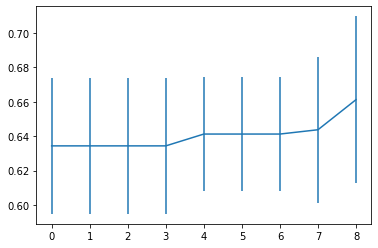

In [65]:
plt.errorbar(np.arange(clf.cv_results_['mean_test_score'].size),
       clf.cv_results_['mean_test_score'],
       clf.cv_results_['std_test_score'])

### Evaluation

In [35]:
# Prediction
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.57      0.80      0.67         5

    accuracy                           0.60        10
   macro avg       0.62      0.60      0.58        10
weighted avg       0.62      0.60      0.58        10

